In [1]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
local_zip = '/content/drive/MyDrive/BeeMFCC/BeeMFCC.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [4]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

# Function to count the number of files in a directory
def count_files(directory):
    file_count = sum([len(files) for _, _, files in os.walk(directory)])
    return file_count

# Define the folder paths for training, validation, and test data
base_dir = "/tmp/BeeMFCC"
TRAINING_DIR = os.path.join(base_dir, "TrainMFCC")
VALIDATION_DIR = os.path.join(base_dir, "ValMFCC")
TEST_DIR = os.path.join(base_dir, "TestMFCC")

# Count the number of files in each directory
training_file_count = count_files(TRAINING_DIR)
validation_file_count = count_files(VALIDATION_DIR)
test_file_count = count_files(TEST_DIR)

print("Training files:", training_file_count)
print("Validation files:", validation_file_count)
print("Test files:", test_file_count)


Training files: 14000
Validation files: 2000
Test files: 4000


In [6]:
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

# Function to load MFCC features from numpy arrays
def load_data(directory):
    mfcc_features = []
    labels = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if not os.path.isdir(label_dir):
            continue
        for filename in os.listdir(label_dir):
            file_path = os.path.join(label_dir, filename)
            if not os.path.isfile(file_path):
                continue
            mfcc = np.load(file_path)
            mfcc_features.append(mfcc)
            labels.append(label)
    return mfcc_features, labels

# Folder paths for training, validation, and test data
TRAINING_DIR = "/tmp/BeeMFCC/TrainMFCC"
VALIDATION_DIR = "/tmp/BeeMFCC/ValMFCC"
TEST_DIR = "/tmp/BeeMFCC/TestMFCC"

# Load training data
train_mfcc_features, train_labels = load_data(TRAINING_DIR)

# Load validation data
val_mfcc_features, val_labels = load_data(VALIDATION_DIR)

# Load test data
test_mfcc_features, test_labels = load_data(TEST_DIR)

# Convert labels to numeric values
label_encoder = LabelEncoder()
encoded_train_labels = label_encoder.fit_transform(train_labels)
encoded_val_labels = label_encoder.transform(val_labels)
encoded_test_labels = label_encoder.transform(test_labels)

# Convert the data to NumPy arrays
X_train = np.array(train_mfcc_features)
y_train = np.array(encoded_train_labels)

X_val = np.array(val_mfcc_features)
y_val = np.array(encoded_val_labels)

X_test = np.array(test_mfcc_features)
y_test = np.array(encoded_test_labels)

# Reshape the input data
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Determine the shape of the MFCC features
input_shape = X_train.shape[1:]

# Define the model architecture
def create_model(input_shape):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(16, 3, activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

# Create the model
model = create_model(input_shape=input_shape)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define the callback for stopping training
class StopTrainingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') >= 0.99:
            print("\nnWhen reaching at 99% accuracy. Stopping training.")
            self.model.stop_training = True

# Train the model with the callback
stop_training_callback = StopTrainingCallback()
history = model.fit(X_train, y_train, epochs=120, validation_data=(X_val, y_val), callbacks=[stop_training_callback])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Epoch 1/120
438/438 [==============================] - 4s 7ms/step - loss: 0.7238 - accuracy: 0.6359 - val_loss: 0.4739 - val_accuracy: 0.7865
Epoch 2/120
438/438 [==============================] - 3s 6ms/step - loss: 0.4690 - accuracy: 0.7689 - val_loss: 0.4019 - val_accuracy: 0.8100
Epoch 3/120
438/438 [==============================] - 3s 7ms/step - loss: 0.4072 - accuracy: 0.8129 - val_loss: 0.4385 - val_accuracy: 0.8030
Epoch 4/120
438/438 [==============================] - 4s 10ms/step - loss: 0.3586 - accuracy: 0.8378 - val_loss: 0.3958 - val_accuracy: 0.8140
Epoch 5/120
438/438 [==============================] - 3s 6ms/step - loss: 0.3364 - accuracy: 0.8451 - val_loss: 0.3716 - val_accuracy: 0.8350
Epoch 6/120
438/438 [==============================] - 3s 6ms/step - loss: 0.3250 - accuracy: 0.8541 - val_loss: 0.3000 - val_accuracy: 0.8645
Epoch 7/120
438/438 [==============================] - 3s 8ms/step - loss: 0.2992 - accuracy: 0.8701 - val_loss: 0.2989 - val_accuracy: 0.868

In [13]:
model.save('/content/drive/MyDrive/Models/CNNsigmoid1D.h5')

In [8]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions (0 or 1)

# Calculate precision, recall, F1-score, and accuracy
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

# Print the results
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Accuracy:", accuracy)


125/125 [==============================] - 0s 2ms/step
Precision: 0.9546625450798557
Recall: 0.9265
F1-score: 0.9403704643491498
Accuracy: 0.94125


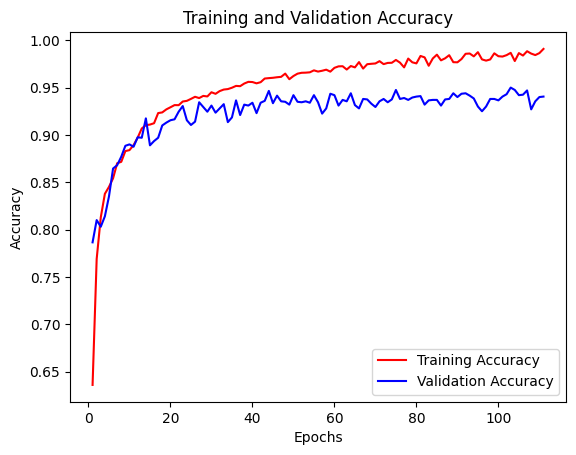

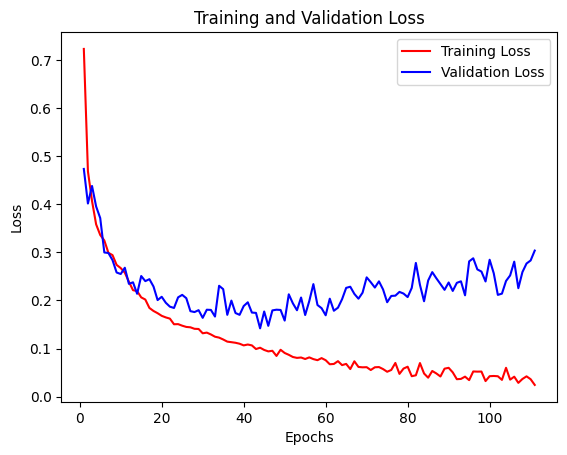

In [9]:
import matplotlib.pyplot as plt

# Get the accuracy and loss values from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Generate the epochs values
epochs = range(1, len(acc) + 1)

# Create the plot for accuracy
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Create the plot for loss
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
